In [3]:
from cucim.skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.transform import AffineTransform, ProjectiveTransform
from cucim.skimage.registration import optical_flow_ilk
from cucim.skimage.transform import rotate, warp
from cucim.skimage.util import img_as_ubyte, img_as_float, img_as_uint
from tifffile import TiffFile, xml2dict
from pathlib import Path
import numpy as np
import cupy as cp
import tifffile
import zarr
import cv2
import os

In [4]:
cp.cuda.set_allocator(None)

In [5]:
# Plotting
from matplotlib.collections import PolyCollection
from matplotlib import pyplot as plt, patches
plt.style.use('moorman')

In [6]:
from skimage.transform import AffineTransform

def get_SIFT_homography(
    img_fxd,  # Reference image to align to
    img_mvg,  # Image to transform
    min_match_count: int = 10,
    save_img_path=None,
    draw_matches=False,
):
    FLANN_INDEX_KDTREE = 1

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # Find the keypoints and descriptors with SIFT
    kp_fxd, dsc_fxd = sift.detectAndCompute(img_fxd, None)
    kp_mvg, dsc_mvg = sift.detectAndCompute(img_mvg, None)
    index_params = {"algorithm": FLANN_INDEX_KDTREE, "trees": 5}
    search_params = {"checks": 50}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(dsc_fxd, dsc_mvg, k=2)
    # Store all the good matches as per Lowe's ratio test.
    good_matches = list(filter(lambda m: m[0].distance < 0.7 * m[1].distance, matches))

    # Compute 3x3 homography matrix
    if len(good_matches) >= min_match_count:
        fxd_pts = np.array([kp_fxd[m.queryIdx].pt for m, _ in good_matches])
        mvg_pts = np.array([kp_mvg[m.trainIdx].pt for m, _ in good_matches])
        M, mask = cv2.findHomography(mvg_pts, fxd_pts, cv2.RANSAC, 5.0)
        return ProjectiveTransform(M)
    else:
        msg = (
            f"Insufficient no. matches detected to perform image "
            f"registration: {len(good_matches)} matches"
        )
        raise AssertionError(msg)
    
def get_level_shapes(path_to_tiff: os.PathLike) -> dict:
    tf = tifffile.TiffFile(path_to_tiff)
    dims = dict()
    for i, lvl in enumerate(tf.series[0].levels):
        dims[i] = dict(zip(lvl.axes, lvl.shape))
    return dims

def get_level_transform(
    path_to_tiff: os.PathLike,
    level_to: int,
    level_from: int = 0,
) -> AffineTransform:
    """
    Compute the scaling transform (AffineTransform) between two levels of a TIFF pyramid.

    Args:
        path_to_tiff (os.PathLike): Path to the TIFF file.
        level_to (int): Target resolution level.
        level_from (int): Source resolution level (default is 0, i.e. highest res).

    Returns:
        AffineTransform: An affine transform representing the scale between the levels.
    """
    dims = get_level_shapes(path_to_tiff)
    scale_x = dims[level_to]["X"] / dims[level_from]["X"]
    scale_y = dims[level_to]["Y"] / dims[level_from]["Y"]
    return AffineTransform(scale=(scale_x, scale_y))

def get_rotation_transform(img: np.ndarray, angle: float) -> AffineTransform:
    H, W = img.shape
    trans = AffineTransform(translation=(H/2, W/2))
    rot = AffineTransform(rotation=np.deg2rad(angle))
    return trans.inverse + rot + trans

In [7]:
lvl_mvg = 4
lvl_fxd = 5

In [18]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*comet*.tiff'))

store = tifffile.imread(
    tiff_path,
    aszarr=True,
    level=lvl_mvg,
)
z = zarr.open(store)

L_mvg = get_level_transform(tiff_path, lvl_mvg, 0)

img_mvg = z[0]
img_mvg = adjust_gamma(cp.array(img_mvg))
img_mvg = equalize_adapthist(
    img_mvg,
    kernel_size=32,
)
R_mvg = get_rotation_transform(img_mvg, 180)
img_mvg = warp(img_mvg, cp.array(R_mvg.inverse.params))
img_mvg = img_as_ubyte(img_mvg)
img_mvg = img_mvg.get()

In [21]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/raw'
)
tiff_path_fxd = next(data_dir.glob('xenium/*morphology*.tif'))

output_shape = get_level_shapes(tiff_path_fxd)[0]

store = tifffile.imread(
    tiff_path_fxd,
    aszarr=True,
    level=lvl_fxd,
)
z = zarr.open(store)
L_fxd = get_level_transform(tiff_path_fxd, lvl_fxd, 0)

img_fxd = z
img_fxd = adjust_gamma(cp.array(img_fxd))
img_fxd = equalize_adapthist(
    img_fxd,
    kernel_size=32,
)
img_fxd = img_as_ubyte(img_fxd)
img_fxd = img_fxd.get()

In [22]:
H = get_SIFT_homography(
    img_fxd,
    img_mvg,
)

In [23]:
img_mvg_wrp = warp(
    cp.array(img_mvg),
    cp.array(H.inverse.params),
    output_shape=img_fxd.shape,
)

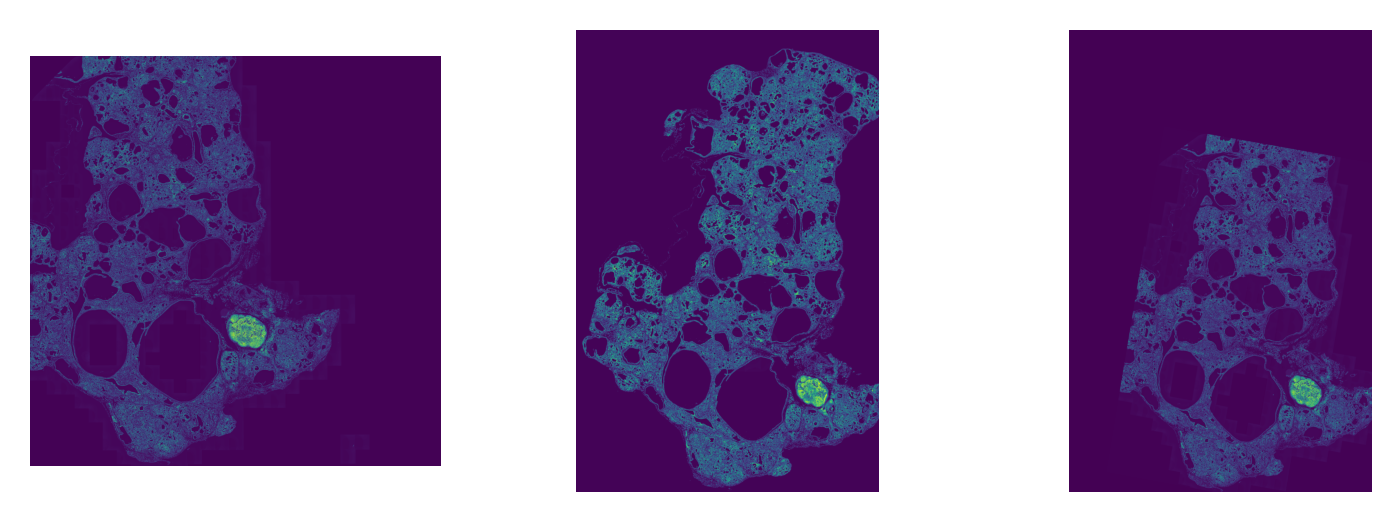

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

import numpy as np

axes[0].imshow(img_mvg)
axes[1].imshow(img_fxd)
axes[2].imshow(img_mvg_wrp.get())
for ax in axes:
    ax.axis('off')

In [25]:
output_shape = (output_shape['Y'], output_shape['X'])

In [26]:
def affine_params_rc(T: AffineTransform):
    # Build matrix/offset for ndimage in (row, col) order from T.inverse (x,y).
    A = T.inverse.params  # 3x3, mapping [x_out,y_out,1] -> [x_in,y_in,1]
    a, b, tx = A[0, 0], A[0, 1], A[0, 2]
    c, d, ty = A[1, 0], A[1, 1], A[1, 2]
    # rc form: r_in = d*r_out + c*c_out + ty ; c_in = b*r_out + a*c_out + tx
    matrix_rc  = cp.asarray([[d, c], [b, a]], dtype=cp.float32)
    offset_rc  = cp.asarray([ty, tx], dtype=cp.float32)
    return matrix_rc, offset_rc

def warp_affine(img, T: AffineTransform, output_shape, order=3, mode="nearest", cval=0.0):
    M, off = affine_params_rc(T)
    from cupyx.scipy.ndimage import affine_transform
    return affine_transform(
        img, matrix=M, offset=off, output_shape=output_shape,
        order=order, mode='constant', cval=cval,
    )


In [27]:
def get_warped_img(
    tiff_path,
    channel,
    output_shape
):
    store = tifffile.imread(
        tiff_path,
        aszarr=True,
        level=0,
    )
    z = zarr.open(store)

    img_mvg = z[channel][:]
    T = (L_mvg + R_mvg + H + L_fxd.inverse)
    img_mvg = warp_affine(
        cp.array(img_mvg),
        T,
        output_shape=output_shape,
        order=1
    ).get()
    clahe = cv2.createCLAHE(clipLimit=5)
    img_mvg = clahe.apply(img_as_uint(img_mvg))
    return img_mvg

In [28]:
from tifffile import TiffFile
import xml.etree.ElementTree as ET
import re

_attr_rx = lambda k: re.compile(rf'({k}\s*=\s*")([^"]*)(")')

def patch_pixels_attrs(path: str | Path, updates: dict[str, str | int]) -> None:
    """
    Change attributes inside the <Pixels …> element of an OME-TIFF *in place*.

    `updates`  e.g. {"SizeX": 51134, "SizeY": 78136}

    Fails if any replacement would change the byte length.
    """
    with TiffFile(str(path), mode="r+b") as tif:
        tag = tif.pages[0].tags["ImageDescription"]
        xml = tag.value.decode("utf-8") if isinstance(tag.value, bytes) else tag.value
        new_xml = xml

        for key, val in updates.items():
            m = _attr_rx(key).search(new_xml)
            if not m:
                raise KeyError(f'"{key}" not found in <Pixels> element')
            old = m.group(2)
            val = str(val)
            # splice replacement
            new_xml = f"{new_xml[:m.start(2)]}{val}{new_xml[m.end(2):]}"

        return new_xml

In [29]:
md_in = tifffile.xml2dict(tifffile.TiffFile(tiff_path_fxd).ome_metadata)
pixels = md_in['OME']['Image']['Pixels']
ome_metadata = patch_pixels_attrs(
    tiff_path,
    {k: pixels[k] for k in ['SizeX', 'SizeY', 'PhysicalSizeX', 'PhysicalSizeY']}
)

In [34]:
import cv2
import numpy as np
import tifffile as tiff
from tifffile import xml2dict

def write_pyramidal_ome_tiff_incremental(
    src_ome_path: str,
    out_path: str,
    ome_metadata,
    get_warped_img,                 # callable: chan -> 2D ndarray (H, W)
    channels=None,                  # list[int] or None = all
    tile=(512, 512),              # multiples of 16 are safest
    compression="zlib",             # or "lzma", "zstd", "jpegxl" if available
    levels=(2, 4, 8, 16),           # integer downsample factors
):
    # 1) Read geometry and original OME-XML (to embed on first page)
    with tiff.TiffFile(src_ome_path) as tf:
        ome_xml = ome_metadata
        s = tf.series[0]
        dtype = s.dtype
        if channels is None:
            C = int(s.shape[-3]) if len(s.shape) >= 3 else 1
            channels = list(range(C))

    # 2) Stream write: one channel at a time
    with tiff.TiffWriter(out_path, bigtiff=True) as tw:
        for i, c in enumerate(channels):
            print(i)
            base = get_warped_img(src_ome_path, c, output_shape)
            H, W = base.shape
            if base.dtype != dtype:
                base = base.astype(dtype, copy=False)

            # Base page (reserve subIFDs for this channel's pyramid)
            kw = dict(tile=tile, compression=compression,
                      photometric="minisblack", subifds=len(levels),
                      metadata=None)
            if i == 0:
                kw["description"] = ome_xml          # keep original OME-XML
            tw.write(base, **kw)

            # Reduced-resolution pages for this channel
            for ds in levels:
                h, w = int(H / ds), int(W / ds)
                lvl = cv2.resize(base, (w, h), interpolation=cv2.INTER_AREA)
                lt = (min(tile[0], h), min(tile[1], w))
                tw.write(
                    lvl.astype(dtype, copy=False),
                    tile=lt,
                    compression=compression,
                    photometric="minisblack",
                    subfiletype=1,   # ReducedImage
                    metadata=None,
                )


In [37]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*comet*.tiff'))

write_pyramidal_ome_tiff_incremental(
    tiff_path,
    str(tiff_path).replace('.ome.tiff', '_warped.ome.tiff'),
    ome_metadata,
    channels=None,
    get_warped_img=get_warped_img,
    levels=(2, 4, 8, 16, 32, 64),
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [20]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*comet*.tiff'))

write_warped_pyramidal_ome_tiff(
    tiff_path,
    str(tiff_path).replace('.ome.tiff', '_warped.ome.tiff'),
    channels=[0, 1, 2],
    get_warped_img=get_warped_img,
    downsample_levels=(2, 4, 8, 16, 32, 64),
)

NameError: name 'write_warped_pyramidal_ome_tiff' is not defined

In [11]:
T = (L_mvg + R_mvg + H + L_fxd.inverse)

In [12]:
from cucim.skimage.transform import warp_coords, AffineTransform
from cupyx.scipy.ndimage import map_coordinates, affine_transform

In [103]:
img_wrp = warp_affine(
    cp.array(img_mvg),
    T,
    output_shape=output_shape,
    order=1
).get()

In [104]:
clahe = cv2.createCLAHE(clipLimit=10)
img_wrp = clahe.apply(img_as_uint(img_wrp))

In [28]:
from cucim.skimage.exposure import adjust_gamma

In [29]:
img_wrp = adjust_gamma(cp.array(img_wrp))

In [71]:
img_wrp_small = img_wrp[::4, ::4]

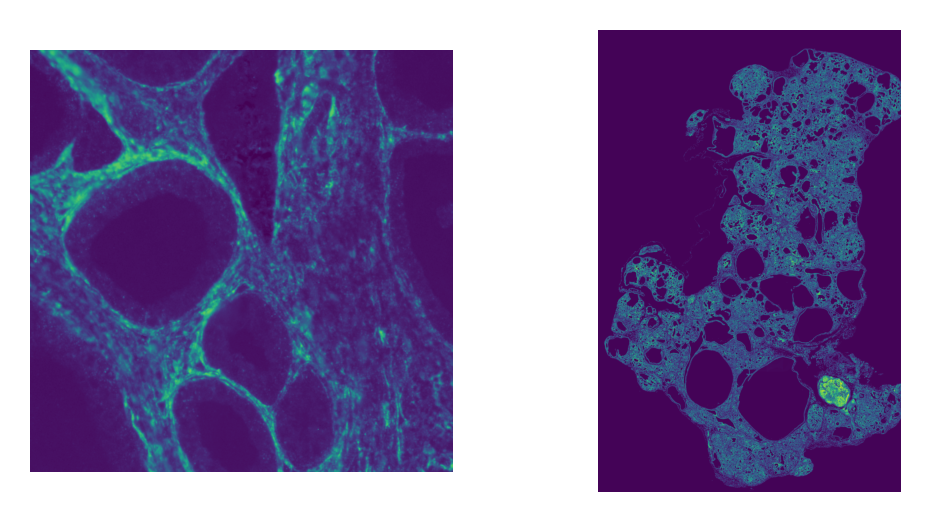

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

import numpy as np

n = 28000
axes[0].imshow(img_wrp[n:n+1000, n:n+1000], vmax=img_wrp.max())
axes[1].imshow(img_fxd)
for ax in axes:
    ax.axis('off')

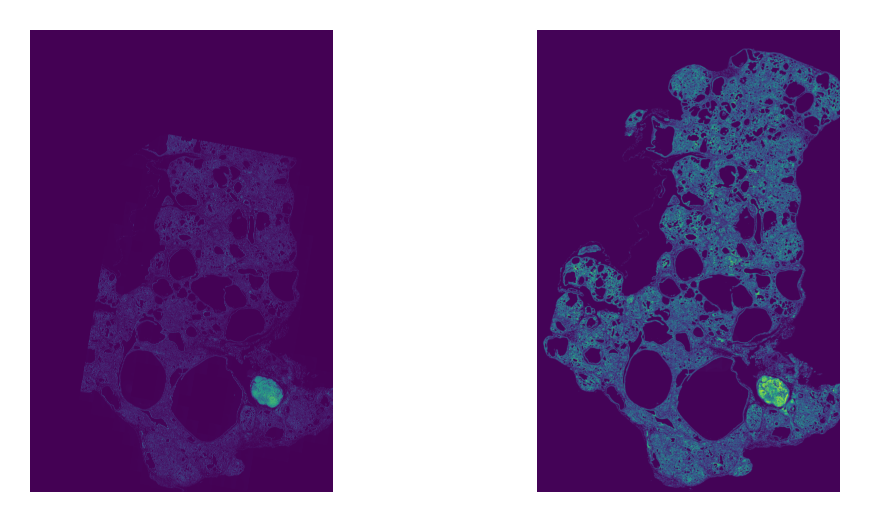

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

import numpy as np

n = 28000
axes[0].imshow(img_mvg)
axes[1].imshow(img_fxd)
for ax in axes:
    ax.axis('off')

NameError: name 'img_mvg_small' is not defined

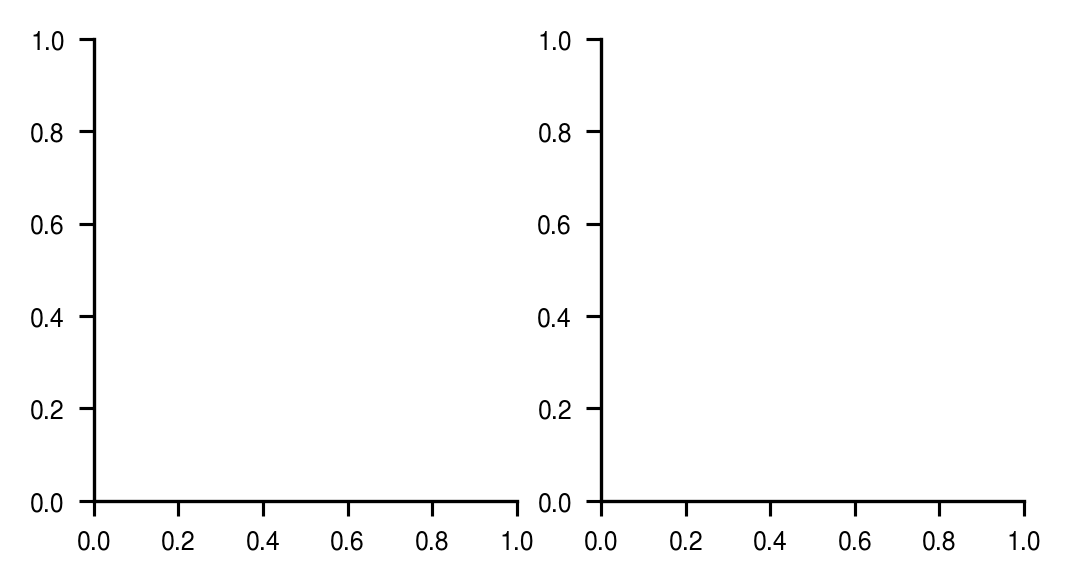

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

import numpy as np

axes[0].imshow(img_mvg_small.get())
axes[1].imshow(img_fxd_wrp_small.get())
for ax in axes:
    ax.axis('off')

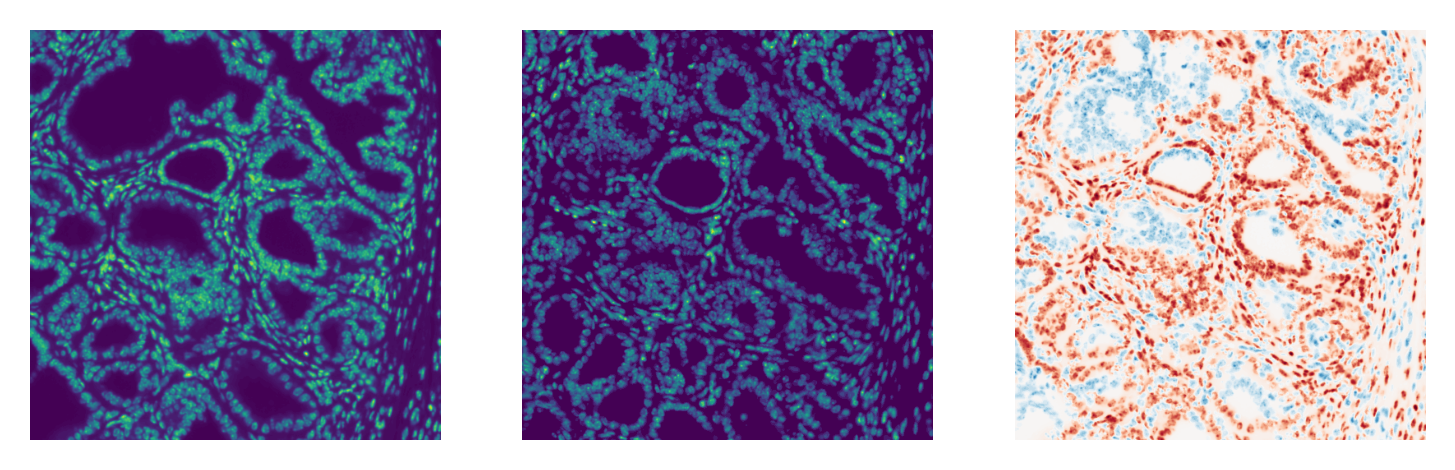

In [160]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

import numpy as np

xmin = 9000
xmax = 9500
ymin = 16000
ymax = 16500

axes[0].imshow(img_mvg_wrp[ymin:ymax, xmin:xmax].get())
axes[1].imshow(img_fxd_wrp[ymin:ymax, xmin:xmax].get())
axes[2].imshow(
    (
        img_mvg_wrp[ymin:ymax, xmin:xmax].get() - \
        img_fxd_wrp[ymin:ymax, xmin:xmax].get()
    ),
    vmin=-0.67,
    vmax=0.67,
    cmap='RdBu_r'
)
for ax in axes:
    ax.axis('off')

(np.float64(-0.5), np.float64(1596.5), np.float64(2440.5), np.float64(-0.5))

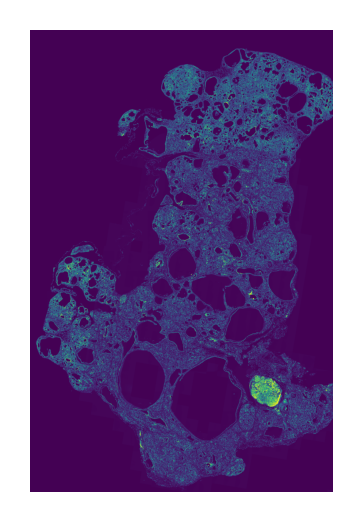

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

import numpy as np

ax.imshow(np.abs(img_mvg_wrp_small.get() - img_fxd_small.get()), vmin=0, vmax=img_mvg_wrp_small.max())
ax.axis('off')

In [14]:
img_mvg_wrp.shape

(19534, 12783)

In [190]:
from matplotlib import pyplot as plt
import numpy as np

channels = [20, 22, -3]
x = 24000
y = 22000
w = 896

img = torch.tensor(z[channels, x:x+w, y:y+w]) / 4096

In [191]:
outs = model.get_intermediate_layers(
    img.unsqueeze(0).to(torch.float),
)
emb = outs[-1].detach()[0]

In [200]:
(img.sum(0) > 0.25).flatten().shape

torch.Size([802816])

In [202]:
img.shape

torch.Size([3, 896, 896])

In [203]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6, whiten=True)
projection = pca.fit_transform(emb)

In [205]:
projection.shape

(3136, 6)

(np.float64(-0.5), np.float64(55.5), np.float64(55.5), np.float64(-0.5))

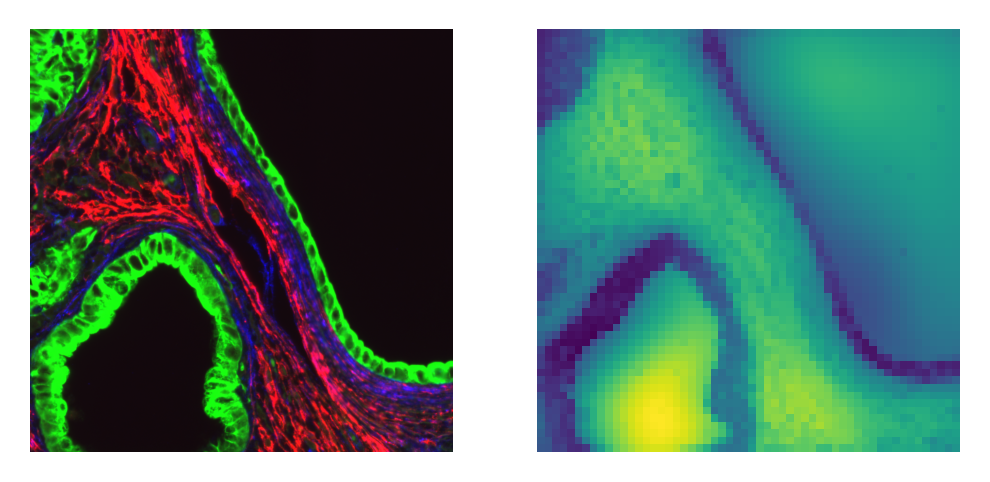

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

axes[0].imshow(img.swapaxes(0, -1))
axes[0].axis('off')

axes[1].imshow(projection[:, 5].reshape(56, 56, 1, order='F'))
axes[1].axis('off')